In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm
from src.models.components.mlp import MyMLP

from torchvision.datasets import MNIST
from PIL import Image


from torchvision import transforms
import torchvision

import os
import copy

from src.models.components.noise_schedules import GeometricNoiseSchedule
from src.energies.base_prior import Prior

from math import sqrt

from model import UNetModelWrapper

device = torch.device('cuda')

### Functions

In [4]:
def normalize(x):
    '''
        normalizes to [-1, 1]
    '''
    # mins = -1 
    # maxs = 1
    mins = -10
    maxs = 10 
    ## [ 0, 1 ]
    x = (x - mins) / (maxs - mins + 1e-5)
    ## [ -1, 1 ]
    x = x * 2 - 1
    
    return x

def unnormalize(x, mins=-10, maxs=10):
    '''
        x : [ -1, 1 ]
    '''
    # assert x.max() <= 1 and x.min() >= -1, f'x range: ({x.min():.4f}, {x.max():.4f})'
    x = (x + 1) / 2
    return x * (maxs - mins) + mins

In [ ]:
class VEReverseSDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, score, noise_schedule):
        super().__init__()
        self.score = score
        self.noise_schedule = noise_schedule

    def f(self, t, x):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones_like(x).to(x.device)

        score = self.score(t, x.view(-1, 1, dim, dim)).view(x.shape)
        return self.g(t, x).pow(2) * score

    def g(self, t, x):
        g = self.noise_schedule.g(t)
        return g

In [27]:
class VEReverseSDE_combined(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, model, diffusion_model, noise_schedule):
        super().__init__()
        self.model = model
        self.diffusion_model = diffusion_model
        self.noise_schedule = noise_schedule

    def f(self, t, x):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones_like(x).to(x.device)

        score_diff = self.model(t, x.view(-1, 1, dim, dim)).view(x.shape) #DEM - diffusion_score
        diffusion_score = self.diffusion_model(t, x.view(-1, 1, dim, dim)).view(x.shape)
        score = score_diff + diffusion_score
        return self.g(t, x).pow(2) * score

    def g(self, t, x):
        g = self.noise_schedule.g(t)
        return g

In [28]:
def euler_maruyama_step(sde, x, t, dt):
    # Calculate drift and diffusion terms
    drift = sde.f(t, x) * dt

    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones_like(x).to(device)
    diffusion = sde.g(t, x) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + drift + diffusion
    return x_next, drift

def integrate_sde(sde, x0, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    samples = []
    with torch.no_grad():
        for t in times:
            x, f = euler_maruyama_step(sde, x, 1-t, dt)
            samples.append(x)
    return torch.stack(samples)

def generate_samples(reverse_sde, num_samples, t_span=(0, 1)):
    samples = prior.sample(num_samples)
    return integrate_sde(
        sde=reverse_sde,
        x0=samples,
        t_span=t_span,
        dt=1e-2,
    )[-1]

### Pre-trained Diffusion

In [29]:
dim = 28
dimensionality = dim**2

batch_size = 128

EPS = 1e-6

# Data Details
noise_schedule = GeometricNoiseSchedule(sigma_min=0.01, sigma_max=sqrt(18))

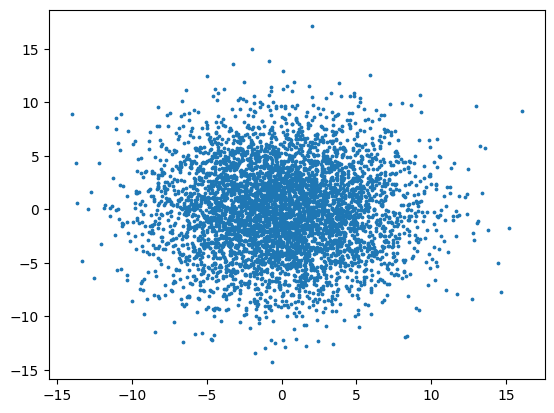

In [30]:
prior = Prior(dim=dimensionality, device=device, scale = noise_schedule.h(1) ** 0.5)
x1_samples = prior.sample(5000).detach().cpu()
plt.scatter(x1_samples[:, 0], x1_samples[:, 1], s=3)

In [31]:
# Data Details

train_data = torchvision.datasets.MNIST("../data", train=True, transform=torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
    ]), download=True)

test_data = torchvision.datasets.MNIST("../data", train=False, transform=torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
    ]), download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [32]:
class EvenMNIST(MNIST):
    def __init__(self, root, train=True, transform=None, download=False):
        self.mnist = torchvision.datasets.MNIST(root, train=train, transform=None, download=download)
        # Filter only the even-numbered digits (0, 2, 4, 6, 8)
        self.indices = [i for i, label in enumerate(self.mnist.targets) if label % 2 == 0]
        self.data = self.mnist.data[self.indices]
        self.targets = self.mnist.targets[self.indices]
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)
        return img, target

# Example usage:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

even_mnist = EvenMNIST("../data", train=True, transform=transform, download=True)
train_loader_even = DataLoader(even_mnist, batch_size=batch_size, shuffle=True , drop_last=True)

# Check the first batch of the filtered dataset
for images, labels in train_loader_even:
    print(labels)  # Should only contain even labels (0, 2, 4, 6, 8)
    break

tensor([6, 8, 6, 8, 8, 6, 2, 0, 2, 0, 8, 4, 0, 2, 8, 2, 2, 4, 0, 4, 2, 2, 4, 4,
        4, 0, 4, 0, 6, 4, 8, 4, 8, 0, 0, 2, 8, 0, 2, 2, 2, 4, 8, 4, 6, 2, 0, 6,
        0, 4, 6, 2, 6, 6, 6, 2, 2, 4, 0, 2, 2, 6, 6, 4, 8, 8, 0, 4, 6, 8, 0, 2,
        0, 8, 2, 2, 6, 6, 4, 0, 4, 0, 0, 2, 2, 8, 0, 0, 2, 0, 8, 4, 8, 4, 6, 6,
        4, 6, 6, 2, 4, 2, 0, 0, 8, 0, 2, 0, 2, 8, 0, 8, 6, 2, 2, 4, 4, 8, 8, 0,
        0, 8, 2, 8, 6, 6, 4, 4])


In [33]:
# def score_loss(vectorfield, x, t, noise_schedule):
#     h_t = noise_schedule.h(t.unsqueeze(1))
    
#     z = torch.randn_like(x)
#     xt = x + z * h_t ** 0.5

#     s_pred = vectorfield(t, xt.view(-1, 1, dim, dim)).view(x.shape)
#     s_true = - (xt - x)/ (h_t + 1e-3)
    
#     lambda_t = 1 /(h_t + 1e-3)
#     s_diff =  torch.linalg.vector_norm(s_pred - s_true, dim=-1) ** 2 #lambda_t *
#     return s_diff.mean()    


def score_loss(score_net, x, t, noise_schedule):
    h_t = noise_schedule.h(t.unsqueeze(1))

    z = torch.randn_like(x)
    xt = x + z * h_t ** 0.5

    s_pred = score_net(t, xt.view(-1, 1, dim, dim)).view(x.shape)
    s_true = - z 
    s_diff =  torch.sum((s_pred * h_t ** 0.5 - s_true) ** 2, dim=(-1)) #* lambda_t
    return s_diff.mean()    

In [34]:
score_net = UNetModelWrapper(dim=(1, dim, dim), num_channels=32, num_res_blocks=2).to(device)
optimizer = torch.optim.Adam(score_net.parameters(), lr=1e-3)
num_epochs = 25

In [35]:
PATH = 'sampling_task/'
f_name = 'even_mnist_score_net.pt'

if os.path.exists(PATH + f_name):
    score_net.load_state_dict(torch.load(PATH + f_name, weights_only=True))
    score_net.eval()
else:
    for epoch in range(num_epochs):
        for x0, _ in train_loader_even:
            x0 = x0.to(device)
            x0 = x0.view(batch_size, dimensionality)
            # x0 = x0.view(batch_size, 1, dim, dim).to(device)
            optimizer.zero_grad()

            t = torch.rand(len(x0), device=device)
            loss = score_loss(score_net, x0, t, noise_schedule)
            
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch}, Loss: {loss.item()}')

        if epoch % 1 == 0:
            # integrate the SDE
            num_samples = 64
            ve_reverse_sde = VEReverseSDE(score_net, noise_schedule)
            samples = generate_samples(ve_reverse_sde, num_samples)
            samples = samples.detach().cpu()
            samples = samples.view(num_samples, 1, dim, dim)
            torchvision.utils.save_image(samples, f'trained_cfm.png', nrow=8)

    torch.save(score_net.state_dict(), PATH + f_name)

In [36]:
num_samples = 64
ve_reverse_sde = VEReverseSDE(score_net, noise_schedule)
samples = generate_samples(ve_reverse_sde, num_samples)
samples = samples.detach().cpu()
samples = samples.view(num_samples, 1, dim, dim)
torchvision.utils.save_image(samples, f'trained_cfm.png', nrow=8)

### Energy Model

In [37]:
from sde_sampler.distr.nice import Nice

In [38]:
nice = Nice(dataset='mnist')

/home/mila/t/tara.akhoundsadegh/active_inference/sde_sampler/sde_sampler/distr/nice.py:247: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mean = torch.load(mean_data_path).r

In [39]:
def log_prob(samples):
    p = energy_net(samples).log_softmax(dim=-1)
    return p.squeeze()

### Energy Estimator


In [40]:
# sample from a tensor
def sample_from_tensor(tensor, num_samples):
    idx = torch.randint(0, tensor.shape[0], (num_samples,))
    return tensor[idx]


def estimate_grad_Rt_high_t(xt,
                            t,
                            energy, 
                            diffusion_samples,
                            noise_schedule,
                            num_mc_samples=100):

    repeated_xt = xt.unsqueeze(0)
    h_t  = noise_schedule.h(t)

    q_diffusion_proposal = sample_from_tensor(diffusion_samples, num_mc_samples)
    q_samples = q_diffusion_proposal

    
    with torch.no_grad():         
        log_p_xt = - (torch.linalg.vector_norm((q_samples.to(device) - repeated_xt.repeat(num_mc_samples, 1)), dim=-1) ** 2 
                / (2 * h_t.squeeze()))          
        log_weights = log_p_xt
        denoising_score = - ((repeated_xt.repeat(num_mc_samples, 1) - q_samples) 
                         / h_t.squeeze())
        scores = denoising_score 

    estimate = torch.sum(torch.nn.functional.softmax(log_weights, dim=0)[:, None] * scores, dim=0)
    return estimate


def estimate_grad_Rt_low_t(xt,
                           t,
                           energy,
                           diffusion_samples,
                           noise_schedule,
                           num_mc_samples=100):
    repeated_xt = xt.unsqueeze(0)
    h_t  = noise_schedule.h(t)
    device = xt.device
    
    q_normal_proposal = repeated_xt + torch.randn((num_mc_samples,) + xt.size()).to(device) * (h_t ** 0.5)
    q_samples = q_normal_proposal
    
    with torch.no_grad():
        log_p_pre = energy(q_samples)
        log_weights = log_p_pre
        target_score  = torch.vmap(torch.func.grad(lambda x: energy(x)))(q_samples)
        scores = target_score

    estimate = torch.sum(torch.nn.functional.softmax(log_weights, dim=0)[:, None] * scores, dim=0)
    return estimate

In [41]:
from src.models.components.clipper import Clipper
clipper = Clipper(
    should_clip_scores=False, should_clip_log_rewards=False, max_score_norm=50
)

In [42]:
def reward_matching_loss(estimator,
                         model,
                         diffusion_model,
                         energy,
                         x,
                         t,
                         diffusion_samples,
                         noise_schedule,
                         num_mc_samples=100,
                         clip=True
    ):


    x.requires_grad = True

    h_t = noise_schedule.h(t.unsqueeze(1))
    
    # noisy sample: x(t)
    xt = torch.normal(x, h_t**0.5)

    # predicted score
    pred_scores = model(t, xt.view(-1, 1, dim, dim)).view(x.shape)
    diffusion_scores = diffusion_model(t, xt.view(-1, 1, dim, dim)).view(x.shape)

    estimated_scores = torch.vmap(estimator, randomness="different",
                                  in_dims=(0, 0, None, None, None))(
                                    xt,
                                    t,
                                    energy,
                                    diffusion_samples,
                                    noise_schedule,
                                    num_mc_samples=num_mc_samples,
                                ).detach()


    if clip:
        estimated_scores = clipper.clip_scores(estimated_scores)

    err = (
        estimated_scores - (pred_scores + diffusion_scores)
    ) ** 2
    return err.mean()

In [43]:
from src.models.components.prioritised_replay_buffer import SimpleBuffer
buffer = SimpleBuffer(
    dimensionality,
    10000,
    1000,
    initial_sampler=None,
    device=device,
    fill_buffer_during_init=False,
    sample_with_replacement=True,
    prioritize=False,
)

Buffer not initialised, expected that checkpoint will be loaded.


In [44]:
num_samples = 1000
ve_reverse_sde = VEReverseSDE(score_net, noise_schedule)
diffusion_samples = generate_samples(ve_reverse_sde, num_samples)
torchvision.utils.save_image(diffusion_samples.view(num_samples, 1, dim, dim).detach().cpu(),
                             PATH + 'diffusion_samples.png', nrow=20)

In [52]:
def log_prob(x):
    if x.dim() == 1:
        x = x.unsqueeze(0)
    return nice.log_prob(x).squeeze()

In [53]:
t_switch_estimators = 0.7
outer_epochs= 100
inner_epochs = 100

batch_size = 512

diffusion_samples_energy = log_prob(diffusion_samples.detach())
buffer.add(diffusion_samples, diffusion_samples_energy)

train_dataset = TensorDataset(diffusion_samples.detach(), diffusion_samples_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) 

num_mc_samples = 200

In [54]:
#copy vectorfield parameters
model = copy.deepcopy(score_net)
optimizer = Adam(model.parameters(), lr=1e-3)
weighted = False

In [55]:
for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)


            samples_high_t = samples[:batch_size//2]
            samples_low_t = samples[batch_size//2:]
            
            optimizer.zero_grad()

            t = torch.rand(len(samples)).to(device)
            t_high = t[:batch_size//2] * (1-t_switch_estimators) + t_switch_estimators
            t_low = t[batch_size//2:] * t_switch_estimators

            rm_loss_high_t = reward_matching_loss(estimate_grad_Rt_high_t,
                                                  model, 
                                                  score_net,
                                                  log_prob,
                                                  samples_high_t,
                                                  t_high, 
                                                  samples,
                                                  noise_schedule, 
                                                  num_mc_samples=num_mc_samples,
                                                  clip=False
                                                  ) 
            
            rm_loss_low_t = reward_matching_loss(estimate_grad_Rt_low_t,
                                                  model, 
                                                  score_net,
                                                  log_prob,
                                                  samples_low_t,
                                                  t_low, 
                                                  samples,
                                                  noise_schedule, 
                                                  num_mc_samples=num_mc_samples,
                                                  )
            

            

            loss = rm_loss_high_t.mean() + rm_loss_low_t.mean()
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        if epoch % 49 == 0:
            print("Epoch %d | Loss %f" % (epoch, loss.item()))


    # Generate samples using the network
    ve_reverse_sde = VEReverseSDE_combined(model, score_net, noise_schedule)
    samples = generate_samples(ve_reverse_sde, 1000)
    samples_energy = log_prob(samples)

    # Update Buffer 
    buffer.add(samples, samples_energy)

    torchvision.utils.save_image(samples.view(1000, 1, dim, dim).detach().cpu(),
                             PATH + 'samples.png', nrow=20)
    

    # Resample data from the buffer
    samples, samples_energy, _ = buffer.sample(512 * 10)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | Loss 847.975403
Epoch 49 | Loss 474.171204
Epoch 98 | Loss 560.287170


  1%|          | 1/100 [03:45<6:11:32, 225.18s/it]

Epoch 0 | Loss 50.216976
Epoch 49 | Loss 4.728061
Epoch 98 | Loss 4.236321


  2%|▏         | 2/100 [21:15<19:20:51, 710.73s/it]

Epoch 0 | Loss 4.462400
Epoch 49 | Loss 3.487648
Epoch 98 | Loss 4.513361


  3%|▎         | 3/100 [38:44<23:18:37, 865.13s/it]

Epoch 0 | Loss 3.387630
Epoch 49 | Loss 4.366125
Epoch 98 | Loss 2.857900


  4%|▍         | 4/100 [56:18<25:03:42, 939.81s/it]

Epoch 0 | Loss 3.851861
Epoch 49 | Loss 3.219581
Epoch 98 | Loss 3.238847


  5%|▌         | 5/100 [1:13:56<25:55:23, 982.35s/it]

Epoch 0 | Loss 3.504202
Epoch 49 | Loss 3.001427


  5%|▌         | 5/100 [1:26:07<27:16:25, 1033.53s/it]


KeyboardInterrupt: 